Data for dataset 'ridership' downloaded successfully!
Data cleaned successfully.
Daily ridership aggregated successfully with pre-pandemic estimates.
Event data loaded successfully.
Event data merged with ridership data successfully.
Correlation between holidays and ridership in November and December: -0.2722


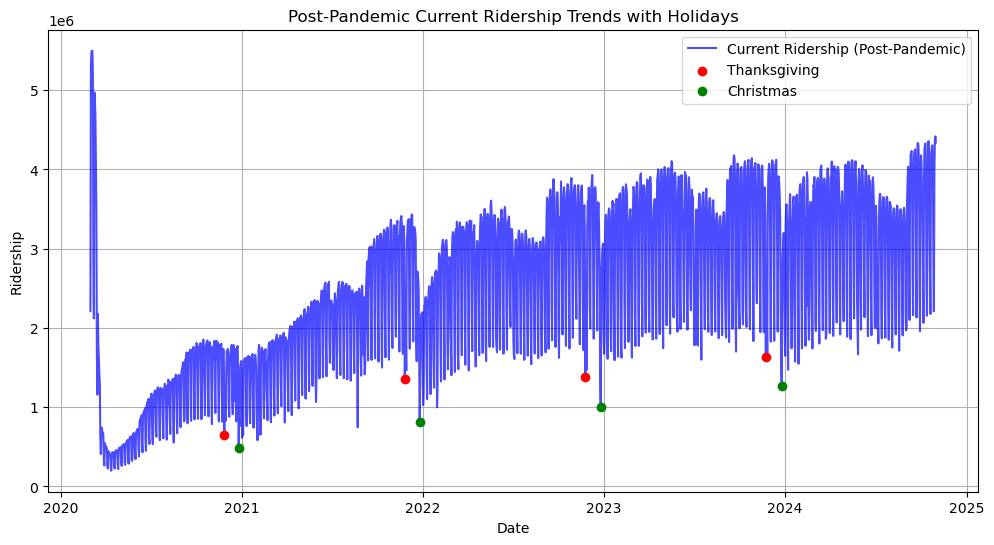

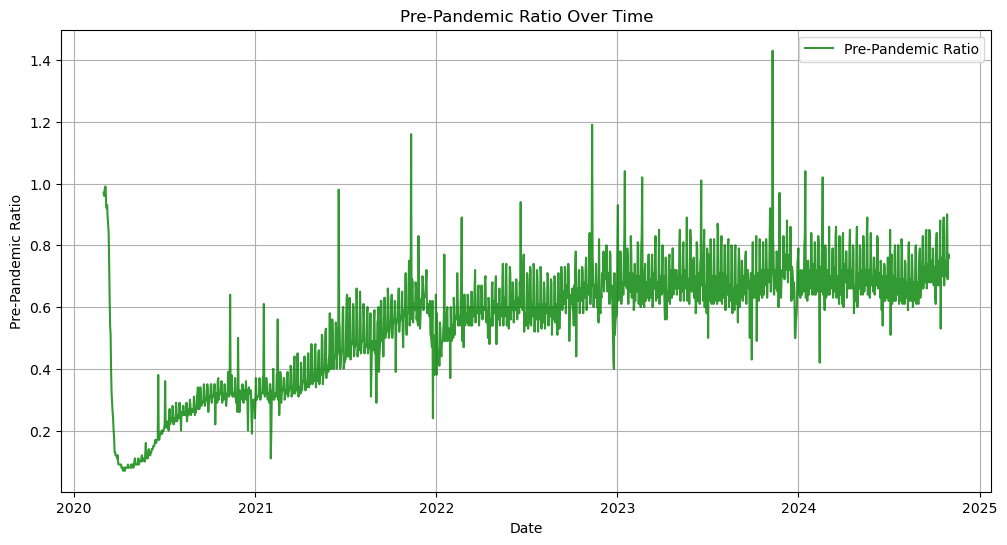

In [ ]:
import pandas as pd
from sodapy import Socrata
import numpy as np
import matplotlib.pyplot as plt

MTA_client = Socrata("data.ny.gov", None, timeout=30)

ds_dictionary = {
    'ridership': 'vxuj-8kew',
    'subway hourly ridership': 'wujg-7c2s',
    'bus hourly ridership': 'kv7t-n8in',
    'major felonies': 'yeek-jhmu',
    'summonses and arrests': '7tfn-twae'
}

class MTATurnstileData:
    def __init__(self, dataset_key='ridership'):
        self.dataset_key = dataset_key
        self.dataset_id = ds_dictionary.get(dataset_key, 'vxuj-8kew')
        self.data = pd.DataFrame()

    def switch_dataset(self, dataset_key):
        if dataset_key in ds_dictionary:
            self.dataset_key = dataset_key
            self.dataset_id = ds_dictionary[dataset_key]
            print(f"Switched to dataset: {dataset_key}")
        else:
            print(f"Dataset key '{dataset_key}' not found. Using current dataset.")

    def download_data(self, start_date=None, end_date=None, limit=5000):
        query = []
        if start_date:
            query.append(f"date >= '{start_date}'")
        if end_date:
            query.append(f"date <= '{end_date}'")
        where_clause = " AND ".join(query) if query else None
        try:
            results = MTA_client.get(self.dataset_id, where=where_clause, limit=limit)
            self.data = pd.DataFrame.from_records(results)
            print(f"Data for dataset '{self.dataset_key}' downloaded successfully!")
        except Exception as e:
            print(f"Error fetching data: {e}")

    def clean_data(self):
        if 'date' in self.data.columns:
            self.data['date'] = pd.to_datetime(self.data['date'])
        self.data.sort_values(by=['date'], inplace=True)
        self.data.drop_duplicates(inplace=True)
        print("Data cleaned successfully.")

    def aggregate_daily_ridership(self):
        date_col = 'date'
        current_ridership_col = 'subways_total_estimated_ridership'
        pre_pandemic_ratio_col = 'subways_of_comparable_pre_pandemic_day'
        if current_ridership_col in self.data.columns and pre_pandemic_ratio_col in self.data.columns:
            self.data[current_ridership_col] = pd.to_numeric(self.data[current_ridership_col], errors='coerce')
            self.data[pre_pandemic_ratio_col] = pd.to_numeric(self.data[pre_pandemic_ratio_col], errors='coerce')
            daily_ridership = self.data.groupby(date_col)[[current_ridership_col, pre_pandemic_ratio_col]].sum().reset_index()
            daily_ridership['pre_pandemic_ridership'] = daily_ridership[current_ridership_col] / daily_ridership[pre_pandemic_ratio_col]
            daily_ridership = daily_ridership.rename(
                columns={
                    current_ridership_col: 'current_ridership',
                    pre_pandemic_ratio_col: 'pre_pandemic_ratio'
                }
            )
            print("Daily ridership aggregated successfully with pre-pandemic estimates.")
            return daily_ridership
        else:
            print(f"Required columns not found in the dataset '{self.dataset_key}'.")
            return pd.DataFrame()

class EventData:
    def __init__(self):
        self.events = pd.DataFrame()

    def load_event_data(self, event_list):
        self.events = pd.DataFrame(event_list)
        self.events['date'] = pd.to_datetime(self.events['date'])
        print("Event data loaded successfully.")

    def merge_with_ridership(self, ridership_data):
        merged_data = pd.merge(ridership_data, self.events, on='date', how='left')
        print("Event data merged with ridership data successfully.")
        return merged_data

def plot_post_pandemic_current_ridership(aggregated_data, event_type, merged_data, post_pandemic_start_date, end_date=None):
    aggregated_data = aggregated_data[aggregated_data['date'] >= pd.to_datetime(post_pandemic_start_date)]
    if end_date:
        aggregated_data = aggregated_data[aggregated_data['date'] <= pd.to_datetime(end_date)]
    plt.figure(figsize=(12, 6))
    plt.plot(aggregated_data['date'], aggregated_data['current_ridership'], label='Current Ridership (Post-Pandemic)', alpha=0.7, color='blue')
    thanksgiving_data = merged_data[merged_data['event_type'] == 'Thanksgiving']
    christmas_data = merged_data[merged_data['event_type'] == 'Christmas']
    plt.scatter(thanksgiving_data['date'], thanksgiving_data['current_ridership'], color='red', label='Thanksgiving', zorder=5)
    plt.scatter(christmas_data['date'], christmas_data['current_ridership'], color='green', label='Christmas', zorder=5)
    plt.xlabel('Date')
    plt.ylabel('Ridership')
    plt.title('Post-Pandemic Current Ridership Trends with Holidays')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_pre_pandemic_ratio(aggregated_data, event_type, merged_data, start_date=None, end_date=None):
    if start_date:
        aggregated_data = aggregated_data[aggregated_data['date'] >= pd.to_datetime(start_date)]
    if end_date:
        aggregated_data = aggregated_data[aggregated_data['date'] <= pd.to_datetime(end_date)]
    plt.figure(figsize=(12, 6))
    plt.plot(aggregated_data['date'], aggregated_data['pre_pandemic_ratio'], label='Pre-Pandemic Ratio', color='green', alpha=0.8)
    plt.xlabel('Date')
    plt.ylabel('Pre-Pandemic Ratio')
    plt.title('Pre-Pandemic Ratio Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

mta_data = MTATurnstileData()
mta_data.download_data(start_date='2020-01-01', limit=1000000)
mta_data.clean_data()
daily_ridership = mta_data.aggregate_daily_ridership()
holiday_events = [
    {'date': '2020-11-26', 'event_type': 'Thanksgiving'},
    {'date': '2020-12-25', 'event_type': 'Christmas'},
    {'date': '2021-11-25', 'event_type': 'Thanksgiving'},
    {'date': '2021-12-25', 'event_type': 'Christmas'},
    {'date': '2022-11-24', 'event_type': 'Thanksgiving'},
    {'date': '2022-12-25', 'event_type': 'Christmas'},
    {'date': '2023-11-23', 'event_type': 'Thanksgiving'},
    {'date': '2023-12-25', 'event_type': 'Christmas'}
]

def compute_holiday_correlation_in_nov_dec(merged_data):
    nov_dec_data = merged_data[merged_data['date'].dt.month.isin([11, 12])].copy()
    
    nov_dec_data['is_holiday'] = nov_dec_data['event_type'].notnull().astype(int)
    
    holiday_correlation = nov_dec_data['is_holiday'].corr(nov_dec_data['current_ridership'])
    print(f"Correlation between holidays and ridership in November and December: {holiday_correlation:.4f}")
    
    return holiday_correlation


event_data = EventData()
event_data.load_event_data(holiday_events)
merged_data = event_data.merge_with_ridership(daily_ridership)
holiday_correlation_nov_dec = compute_holiday_correlation_in_nov_dec(merged_data)
plot_post_pandemic_current_ridership(daily_ridership, 'Holiday', merged_data, post_pandemic_start_date='2020-01-01', end_date='2024-10-31')
plot_pre_pandemic_ratio(daily_ridership, 'Holiday', merged_data, start_date='2020-01-01', end_date='2024-10-31')


The following is the analysis of how holidays affecting bus ridership.

In [ ]:
class MTABusDataSpecificRoute:
    def __init__(self, route_name):
        self.dataset_key = 'bus hourly ridership'
        self.dataset_id = ds_dictionary.get(self.dataset_key, 'kv7t-n8in')
        self.data = pd.DataFrame()
        self.timestamp_column = None
        self.ridership_column = 'ridership'
        self.route_column = 'bus_route'
        self.route_name = route_name

    def detect_timestamp_column(self):
        possible_columns = ['transit_timestamp', 'timestamp', 'time']
        for col in possible_columns:
            if col in self.data.columns:
                self.timestamp_column = col
                print(f"Detected timestamp column: {self.timestamp_column}")
                return
        raise KeyError("No suitable timestamp column found in the dataset.")

    def download_bus_data(self, start_date=None, end_date=None, limit=5000):
        try:

            initial_results = MTA_client.get(self.dataset_id, limit=1)
            self.data = pd.DataFrame.from_records(initial_results)
            self.detect_timestamp_column()  # Detect the correct timestamp column

            # Build the query after detecting timestamp column
            query = [f"{self.route_column} = '{self.route_name}'"]
            if start_date:
                query.append(f"{self.timestamp_column} >= '{start_date}'")
            if end_date:
                query.append(f"{self.timestamp_column} <= '{end_date}'")
            where_clause = " AND ".join(query) if query else None

            results = MTA_client.get(self.dataset_id, where=where_clause, limit=limit)
            self.data = pd.DataFrame.from_records(results)
            print(f"Data for route '{self.route_name}' downloaded successfully!")
        except Exception as e:
            print(f"Error fetching data: {e}")

    def clean_bus_data(self):
        if self.timestamp_column not in self.data.columns:
            raise KeyError(f"Column '{self.timestamp_column}' not found in the dataset.")
        self.data[self.timestamp_column] = pd.to_datetime(self.data[self.timestamp_column], errors='coerce')
        self.data.sort_values(by=[self.timestamp_column], inplace=True)
        self.data.drop_duplicates(inplace=True)
        print(f"Data for route '{self.route_name}' cleaned successfully.")

    def aggregate_bus_ridership(self):
        if self.ridership_column not in self.data.columns:
            raise KeyError(f"Column '{self.ridership_column}' not found in the dataset.")
        self.data[self.ridership_column] = pd.to_numeric(self.data[self.ridership_column], errors='coerce')
        self.data['date_only'] = self.data[self.timestamp_column].dt.date  # Extract only the date
        daily_ridership = self.data.groupby('date_only')[self.ridership_column].sum().reset_index()
        daily_ridership.rename(columns={'date_only': 'date', self.ridership_column: 'daily_ridership'}, inplace=True)
        print(f"Daily ridership for route '{self.route_name}' aggregated successfully.")
        return daily_ridership



In [11]:
sample_data = MTA_client.get('kv7t-n8in', limit=1000)
sample_df = pd.DataFrame.from_records(sample_data)

if 'bus_route' in sample_df.columns:
    unique_routes = sample_df['bus_route'].unique()
    sorted_routes = sorted(unique_routes)  # Sort the routes alphabetically
    print("Available Routes (Sorted):")
    for route in sorted_routes:
        print(route)
else:
    print("'bus_route' column not found in the dataset. Check the dataset structure.")

Available Routes (Sorted):
B1
B100
B103
B11
B12
B13
B14
B15
B16
B17
B2
B20
B24
B25
B26
B3
B31
B32
B35
B36
B37
B38
B39
B41
B42
B43
B44
B44+
B45
B46
B46+
B47
B48
B49
B52
B54
B57
B6
B60
B61
B62
B63
B64
B65
B67
B68
B69
B7
B70
B74
B8
B82+
B83
B84
B9
B99
BM1
BM2
BM5
BX1
BX10
BX11
BX12
BX12+
BX13
BX15
BX16
BX17
BX18
BX19
BX2
BX20
BX21
BX22
BX23
BX24
BX26
BX27
BX28
BX29
BX3
BX30
BX31
BX32
BX33
BX34
BX35
BX36
BX39
BX4
BX40
BX41
BX41+
BX42
BX4A
BX5
BX6
BX6+
BX7
BX8
BX9
BX99
BXM1
BXM10
BXM11
BXM2
BXM3
BXM4
BXM6
BXM7
BXM8
BXM9
M1
M100
M101
M102
M103
M104
M106
M11
M116
M12
M14A+
M14D+
M15
M15+
M2
M20
M21
M22
M23+
M3
M31
M34+
M34A+
M35
M4
M42
M5
M50
M55
M57
M60+
M66
M7
M72
M79+
M8
M86+
M9
M96
M98
M99
Q06
Q07
Q08
Q09
Q1
Q10
Q100
Q101
Q102
Q103
Q104
Q11
Q110
Q111
Q112
Q113
Q114
Q12
Q13
Q15
Q15A
Q17
Q18
Q19
Q2
Q20A
Q20B
Q21
Q22
Q23
Q24
Q25
Q26
Q27
Q28
Q29
Q3
Q30
Q31
Q32
Q33
Q35
Q36
Q37
Q38
Q39
Q4
Q41
Q42
Q43
Q44+
Q46
Q47
Q48
Q49
Q5
Q50
Q52+
Q53+
Q54
Q55
Q56
Q58
Q59
Q60
Q64
Q65
Q66
Q67
Q69
Q70+
Q72
Q76


In [12]:
route_name = 'B1'  # Specify the bus route
start_date = '2020-01-01'

bus_data_B1 = MTABusDataSpecificRoute(route_name)

bus_data_B1.download_bus_data(start_date=start_date, limit=2000000) ### This might take a while. Large dataset
    

Detected timestamp column: transit_timestamp
Data for route 'B1' downloaded successfully!


In [13]:
def compute_event_correlation_nov_dec(daily_ridership, event_data, event_type):
    daily_ridership['date'] = pd.to_datetime(daily_ridership['date'], errors='coerce')
    event_data['date'] = pd.to_datetime(event_data['date'], errors='coerce')

    daily_ridership = daily_ridership[daily_ridership['date'].dt.month.isin([11, 12])]

    merged_data = pd.merge(daily_ridership, event_data, on='date', how='left')
    merged_data[f'is_{event_type.lower()}'] = (merged_data['event_type'] == event_type).astype(int)

    correlation = merged_data[f'is_{event_type.lower()}'].corr(merged_data['daily_ridership'])
    print(f"Correlation between {event_type} (Nov and Dec only) and ridership: {correlation}")
    return correlation


Data for route 'B1' cleaned successfully.
Daily ridership for route 'B1' aggregated successfully.
Correlation between Thanksgiving (Nov and Dec only) and ridership: -0.19784660476251964
Correlation between Christmas (Nov and Dec only) and ridership: -0.21769659030220842
Thanksgiving Correlation: -0.19784660476251964
Christmas Correlation: -0.21769659030220842


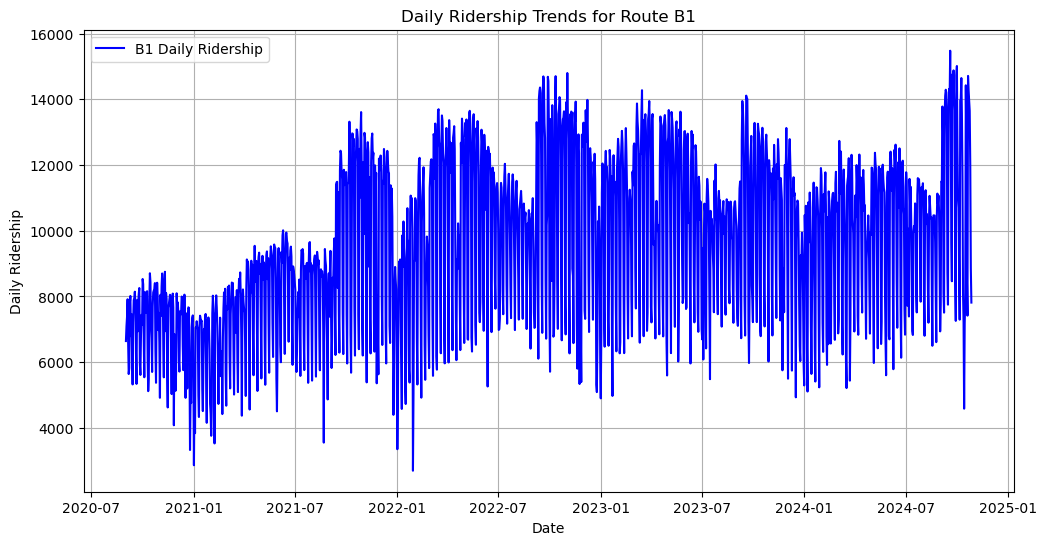

In [14]:
bus_data_B1.clean_bus_data()

daily_ridership = bus_data_B1.aggregate_bus_ridership()

holiday_events = [
    {'date': '2020-11-26', 'event_type': 'Thanksgiving'},
    {'date': '2020-12-25', 'event_type': 'Christmas'},
    {'date': '2021-11-25', 'event_type': 'Thanksgiving'},
    {'date': '2021-12-25', 'event_type': 'Christmas'},
    {'date': '2022-11-24', 'event_type': 'Thanksgiving'},
    {'date': '2022-12-25', 'event_type': 'Christmas'},
    {'date': '2023-11-23', 'event_type': 'Thanksgiving'},
    {'date': '2023-12-25', 'event_type': 'Christmas'}
]
event_data = pd.DataFrame(holiday_events)
event_data['date'] = pd.to_datetime(event_data['date'])

thanksgiving_correlation = compute_event_correlation_nov_dec(daily_ridership, event_data, 'Thanksgiving')
christmas_correlation = compute_event_correlation_nov_dec(daily_ridership, event_data, 'Christmas')

print(f"Thanksgiving Correlation: {thanksgiving_correlation}")
print(f"Christmas Correlation: {christmas_correlation}")

plt.figure(figsize=(12, 6))
plt.plot(daily_ridership['date'], daily_ridership['daily_ridership'], label=f'{route_name} Daily Ridership', color='blue')
plt.xlabel('Date')
plt.ylabel('Daily Ridership')
plt.title(f'Daily Ridership Trends for Route {route_name}')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
route_name = 'Q5'  # Specify the bus route
start_date = '2020-01-01'

bus_data_Q5 = MTABusDataSpecificRoute(route_name)
bus_data_Q5.download_bus_data(start_date=start_date, limit=2000000) ### This might take a while. Large dataset

Detected timestamp column: transit_timestamp
Data for route 'Q5' downloaded successfully!


Data for route 'Q5' cleaned successfully.
Daily ridership for route 'Q5' aggregated successfully.
Correlation between Thanksgiving (Nov and Dec only) and ridership: -0.2180138488078459
Correlation between Christmas (Nov and Dec only) and ridership: -0.26934679457609667
Thanksgiving Correlation: -0.2180138488078459
Christmas Correlation: -0.26934679457609667


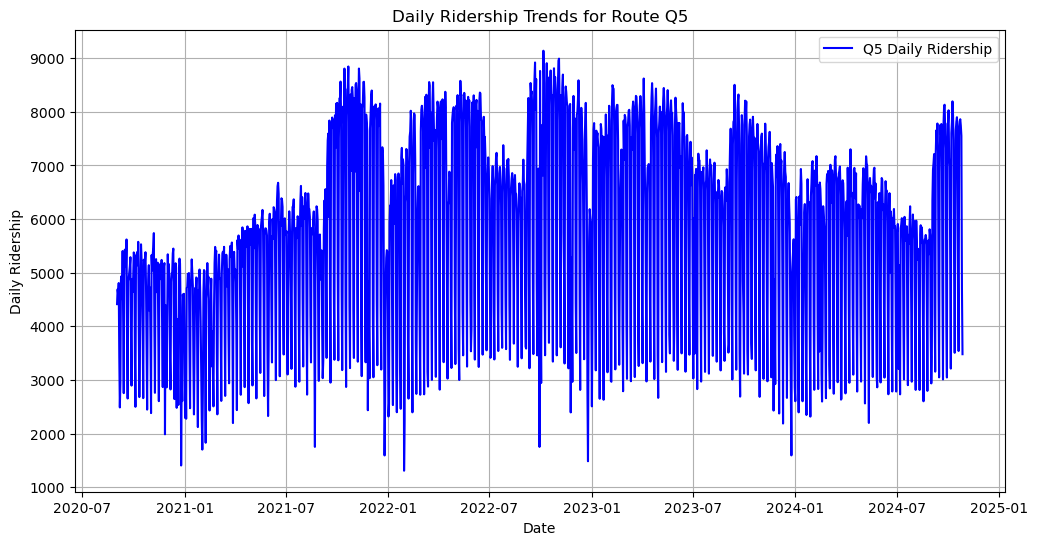

In [16]:
bus_data_Q5.clean_bus_data()

daily_ridership = bus_data_Q5.aggregate_bus_ridership()

holiday_events = [
    {'date': '2020-11-26', 'event_type': 'Thanksgiving'},
    {'date': '2020-12-25', 'event_type': 'Christmas'},
    {'date': '2021-11-25', 'event_type': 'Thanksgiving'},
    {'date': '2021-12-25', 'event_type': 'Christmas'},
    {'date': '2022-11-24', 'event_type': 'Thanksgiving'},
    {'date': '2022-12-25', 'event_type': 'Christmas'},
    {'date': '2023-11-23', 'event_type': 'Thanksgiving'},
    {'date': '2023-12-25', 'event_type': 'Christmas'}
]
event_data = pd.DataFrame(holiday_events)
event_data['date'] = pd.to_datetime(event_data['date'])

thanksgiving_correlation = compute_event_correlation_nov_dec(daily_ridership, event_data, 'Thanksgiving')
christmas_correlation = compute_event_correlation_nov_dec(daily_ridership, event_data, 'Christmas')

print(f"Thanksgiving Correlation: {thanksgiving_correlation}")
print(f"Christmas Correlation: {christmas_correlation}")

plt.figure(figsize=(12, 6))
plt.plot(daily_ridership['date'], daily_ridership['daily_ridership'], label=f'{route_name} Daily Ridership', color='blue')
plt.xlabel('Date')
plt.ylabel('Daily Ridership')
plt.title(f'Daily Ridership Trends for Route {route_name}')
plt.legend()
plt.grid(True)
plt.show()


The correlation is performed between holidays and non-holidays. The correlations show that both holidays have weak negative correlation, meaning that holidays will decrease ridership but not significantly since correlations are close to 0.

For the following, we want to see how holidays affect hourly ridership for certain bus routes.

In [24]:
def plot_hourly_changes_bar(bus_data, event_data):

    bus_data['transit_timestamp'] = pd.to_datetime(bus_data['transit_timestamp'])

    bus_data['ridership'] = pd.to_numeric(bus_data['ridership'], errors='coerce')
    bus_data = bus_data.dropna(subset=['ridership'])

    bus_data['date'] = bus_data['transit_timestamp'].dt.date
    bus_data['hour'] = bus_data['transit_timestamp'].dt.hour

    event_data['date'] = pd.to_datetime(event_data['date']).dt.date
    merged_data = pd.merge(bus_data, event_data, on='date', how='left')
    merged_data['is_holiday'] = merged_data['event_type'].notna()

    hourly_data = merged_data.groupby(['hour', 'is_holiday'])['ridership'].mean().reset_index()
    holiday_data = hourly_data[hourly_data['is_holiday']]
    non_holiday_data = hourly_data[~hourly_data['is_holiday']]

    all_hours = pd.DataFrame({'hour': range(24)})
    holiday_data = all_hours.merge(holiday_data, on='hour', how='left').fillna({'ridership': 0})
    non_holiday_data = all_hours.merge(non_holiday_data, on='hour', how='left').fillna({'ridership': 0})

    bar_width = 0.4
    indices = np.arange(24)  # Hours 0-23

    plt.figure(figsize=(12, 6))
    plt.bar(indices - bar_width / 2, holiday_data['ridership'], width=bar_width, label='Holidays', color='red')
    plt.bar(indices + bar_width / 2, non_holiday_data['ridership'], width=bar_width, label='Non-Holidays', color='blue')

    plt.xlabel('Hour of Day')
    plt.ylabel('Average Ridership')
    plt.title('Q5 Hourly Ridership Trends: Holidays vs Non-Holidays')
    plt.xticks(indices, [str(hour) for hour in range(24)])  # Set x-axis ticks to 0-23
    plt.legend()
    plt.grid(axis='y')
    plt.show()


Data for route 'B1' cleaned successfully.


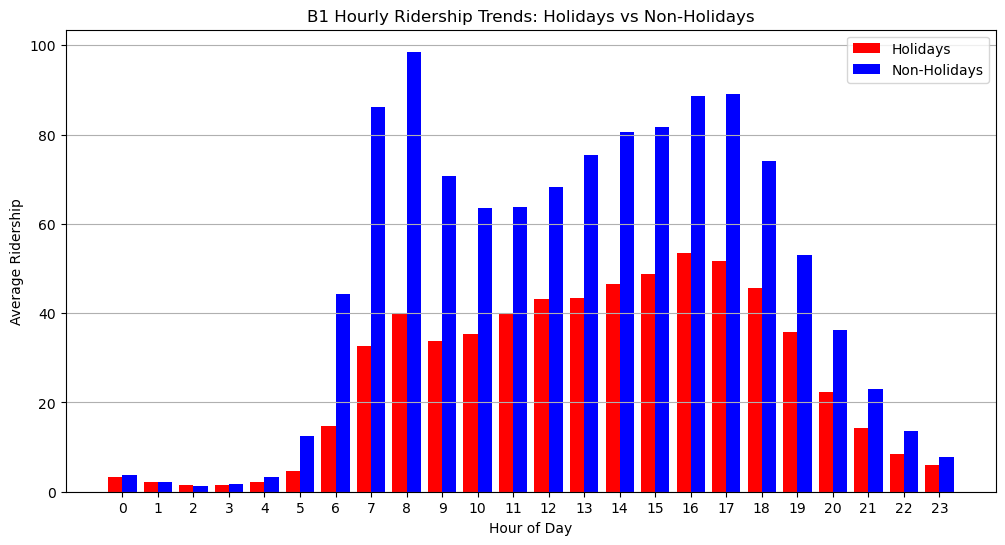

In [23]:
bus_data_B1.clean_bus_data()

bus_data = bus_data_B1.data  

holiday_events = [
    {'date': '2020-11-26', 'event_type': 'Thanksgiving'},
    {'date': '2020-12-25', 'event_type': 'Christmas'},
    {'date': '2021-11-25', 'event_type': 'Thanksgiving'},
    {'date': '2021-12-25', 'event_type': 'Christmas'},
    {'date': '2022-11-24', 'event_type': 'Thanksgiving'},
    {'date': '2022-12-25', 'event_type': 'Christmas'},
    {'date': '2023-11-23', 'event_type': 'Thanksgiving'},
    {'date': '2023-12-25', 'event_type': 'Christmas'}
]
event_data = pd.DataFrame(holiday_events)

plot_hourly_changes_bar(bus_data, event_data)

Data for route 'Q5' cleaned successfully.


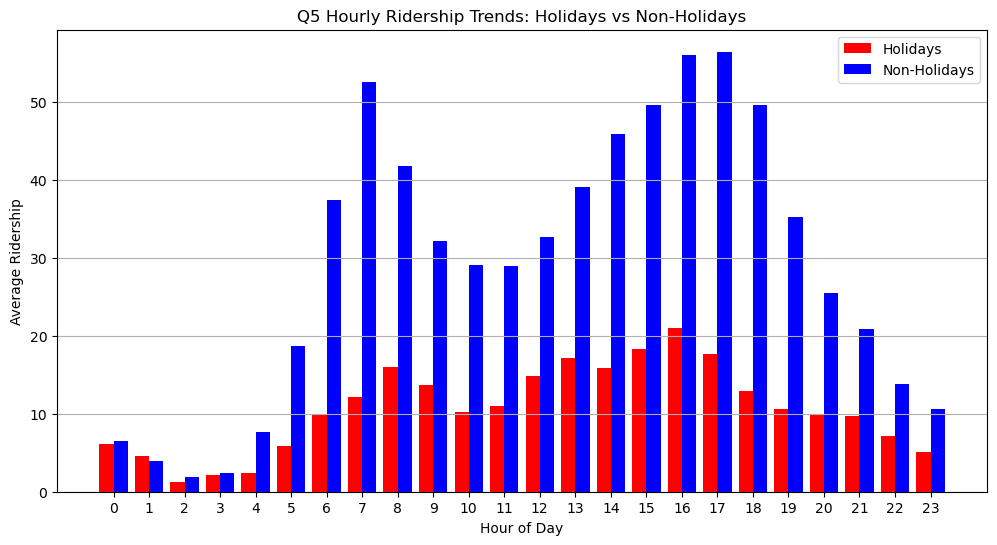

In [25]:
bus_data_Q5.clean_bus_data()
bus_data = bus_data_Q5.data  

holiday_events = [
    {'date': '2020-11-26', 'event_type': 'Thanksgiving'},
    {'date': '2020-12-25', 'event_type': 'Christmas'},
    {'date': '2021-11-25', 'event_type': 'Thanksgiving'},
    {'date': '2021-12-25', 'event_type': 'Christmas'},
    {'date': '2022-11-24', 'event_type': 'Thanksgiving'},
    {'date': '2022-12-25', 'event_type': 'Christmas'},
    {'date': '2023-11-23', 'event_type': 'Thanksgiving'},
    {'date': '2023-12-25', 'event_type': 'Christmas'}
]
event_data = pd.DataFrame(holiday_events)
plot_hourly_changes_bar(bus_data, event_data)

Marathon effect on subway ridership, compared between an NYC marathon day (11/05/2023) and non marathon day (10/29/2023).

In [ ]:
import folium
import pandas as pd

non_marathon_data = pd.read_csv('nonmarathon_10292023.csv') 
marathon_data = pd.read_csv('marathon_11052023.csv') 

non_marathon_data.rename(columns={
    'station_complex': 'Station',
    'latitude': 'Latitude',
    'longitude': 'Longitude',
    'ridership': 'Entries'
}, inplace=True)

marathon_data.rename(columns={
    'station_complex': 'Station',
    'latitude': 'Latitude',
    'longitude': 'Longitude',
    'ridership': 'Entries'
}, inplace=True)


non_marathon_data['Latitude'] = non_marathon_data['Latitude'].round(4)
non_marathon_data['Longitude'] = non_marathon_data['Longitude'].round(4)
marathon_data['Latitude'] = marathon_data['Latitude'].round(4)
marathon_data['Longitude'] = marathon_data['Longitude'].round(4)

non_marathon_daily = non_marathon_data.groupby(['Station'])[['Entries']].sum().reset_index()
marathon_daily = marathon_data.groupby(['Station'])[['Entries']].sum().reset_index()

merged_data = pd.merge(
    non_marathon_daily,
    marathon_daily,
    on=['Station'],
    suffixes=('_non_marathon', '_marathon')
)

merged_data['Ridership_Difference'] = merged_data['Entries_marathon'] - merged_data['Entries_non_marathon']

stations_on_route = [
    "Bay Ridge-95 St (R)", "77 St (R)", "86 St (R)", "59 St (N,R)",
    "4 Av-9 St (F,G,R)", "Atlantic Av-Barclays Ctr (B,D,N,Q,R,2,3,4,5)",
    "Bergen St (2,3)", "DeKalb Av (B,Q,R)", 
    "Queensboro Plaza (7,N,W)", "59 St-Columbus Circle (A,B,C,D,1)",
    "86 St (C,B)", "96 St (C,B)", "125 St (1)", 
    "Central Park North (110 St) (2,3)", "138 St-Grand Concourse (4,5)",
] ### some of the major stations that are close to the route

merged_data = merged_data[merged_data['Station'].isin(stations_on_route)]

coordinates = marathon_data[['Station', 'Latitude', 'Longitude']].drop_duplicates()
merged_data = pd.merge(merged_data, coordinates, on='Station', how='left')
merged_data = merged_data.drop_duplicates(subset=['Station', 'Entries_non_marathon', 'Entries_marathon'])


def get_difference_color(difference):
    if difference > 0:
        return 'green'  # Increased ridership
    elif difference < 0:
        return 'red'  # Decreased ridership
    else:
        return 'blue'  # No change

difference_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

for _, row in merged_data.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=abs(row['Ridership_Difference']) / 1000,  # Scale for visualization, larger radius means larger difference
        popup=f"{row['Station']}:\nDifference: {row['Ridership_Difference']} entries",
        color=get_difference_color(row['Ridership_Difference']),
        fill=True,
        fill_opacity=0.7
    ).add_to(difference_map)

top_two_stations = merged_data.sort_values(by='Ridership_Difference', ascending=False).head(2)

top_two_stations['Percentage_Increase'] = (
    top_two_stations['Ridership_Difference'] / top_two_stations['Entries_non_marathon'] * 100
)

for _, row in top_two_stations.iterrows():
    print(f"Station: {row['Station']}")
    print(f"Ridership Increase: {row['Ridership_Difference']}")
    print(f"Non-Marathon Ridership: {row['Entries_non_marathon']}")
    print(f"Marathon Ridership: {row['Entries_marathon']}")
    print(f"Percentage Increase: {row['Percentage_Increase']:.2f}%\n")

legend_html = """
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 250px; height: 110px; 
            background-color: white; border:2px solid grey; z-index:9999; font-size:14px;
            padding: 10px;">
    <b>Ridership Difference</b><br>
    <i style="background: green; width: 15px; height: 15px; display: inline-block;"></i> Increase in ridership<br>
    <i style="background: red; width: 15px; height: 15px; display: inline-block;"></i> Decrease in ridership<br>
    <i style="background: blue; width: 15px; height: 15px; display: inline-block;"></i> No change
</div>
"""
difference_map.get_root().html.add_child(folium.Element(legend_html))
difference_map.save('nyc_ridership_difference_map.html')

difference_map


Station: 59 St-Columbus Circle (A,B,C,D,1)
Ridership Increase: 28396
Non-Marathon Ridership: 27688
Marathon Ridership: 56084
Percentage Increase: 102.56%

Station: Atlantic Av-Barclays Ctr (B,D,N,Q,R,2,3,4,5)
Ridership Increase: 16797
Non-Marathon Ridership: 17014
Marathon Ridership: 33811
Percentage Increase: 98.72%



In [21]:
print("Unique stations in marathon data:", marathon_data['Station'].unique())

Unique stations in marathon data: ['207 St (1)' '135 St (C,B)' '191 St (1)' 'Bergen St (2,3)' '72 St (C,B)'
 'Nostrand Av (3)' 'Fort Hamilton Pkwy (N)' 'Kings Hwy (F)' '231 St (1)'
 'Crown Hts-Utica Av (3,4)' '59 St (N,R)' '5 Av/59 St (N,R,W)'
 '163 St-Amsterdam Av (C)' 'Cathedral Pkwy (110 St) (1)' 'Rockaway Av (3)'
 'City Hall (R,W)' 'Winthrop St (2,5)' '18 Av (F)' '125 St (1)'
 'Junius St (3)' 'Bay Pkwy (D)' '15 St-Prospect Park (F,G)'
 'Sutphin Blvd (F)' 'Avenue X (F)' '181 St (1)' '28 St (R,W)'
 'Sutter Av-Rutland Rd (3)' '50 St (C,E)' 'Kings Hwy (N)' '145 St (1)'
 '238 St (1)' 'Avenue N (F)' '169 St (F)' '215 St (1)' '30 Av (N,W)'
 'Jamaica-179 St (F)' 'Astoria Blvd (N,W)' '23 St (R,W)' 'Halsey St (L)'
 'Pennsylvania Av (3)' 'Hoyt St (2,3)' 'Bay 50 St (D)' 'Jefferson St (L)'
 'Saratoga Av (3)' 'Morgan Av (L)' 'Ozone Park-Lefferts Blvd (A)'
 'President St-Medgar Evers College (2,5)' 'Montrose Av (L)'
 'Liberty Av (C)' 'Atlantic Av (L)' 'Rector St (1)' '18 Av (N)'
 '81 St-Museum of